In [1]:

import numpy 
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline
pandas.__version__

Using Theano backend.
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


u'0.18.1'

In [2]:
numpy.random.seed(7)

   International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0                                                112                             
1                                                118                             
2                                                132                             
3                                                129                             
4                                                121                             


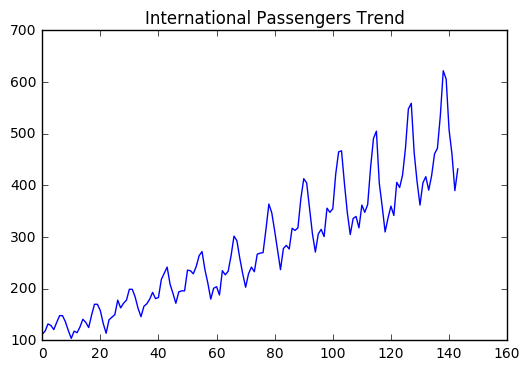

In [3]:
# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
print dataframe.head()
dataset = dataframe.values
dataset = dataset.astype('float32')
plt.plot(dataset)
plt.title("International Passengers Trend")
plt.show()

In [4]:

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print"Length of Training data is %d and Test data is %d" %(len(train), len(test))


Length of Training data is 96 and Test data is 48


In [5]:
'''
Create the dataset by making x(t) as X and x(t+1) as Y

'''
def create_dataset(data_set,look_back):
    X=[]
    Y=[]
    for i in range(len(data_set)-look_back-1):
        curr = numpy.ravel(data_set[i:(i+look_back)])
        X.append(curr)
        nxt = data_set[i+look_back]
        
        Y.append(nxt)
    #print numpy.hstack((numpy.asanyarray(X),numpy.asanyarray(Y)))
    return numpy.array(X),numpy.array(Y)
    

In [6]:
tr_X,tr_Y=create_dataset(train,look_back=2)

In [7]:
tst_X,tst_Y=create_dataset(test,look_back=2)

In [9]:
trainX = numpy.reshape(tr_X, (tr_X.shape[0], tr_X.shape[1], 1))
print numpy.shape(trainX)
testX = numpy.reshape(tst_X, (tst_X.shape[0], tst_X.shape[1], 1))
print numpy.shape(testX)

(93L, 2L, 1L)
(45L, 2L, 1L)


In [12]:

# create and fit the LSTM network
look_back=2
model = Sequential()
model.add(LSTM(16, input_dim=1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, tr_Y, nb_epoch=100, batch_size=1, verbose=1)

Epoch 1/100
93/93 [==============================] - 12s - loss: 0.0569    
Epoch 2/100
93/93 [==============================] - 12s - loss: 0.0180    
Epoch 3/100
93/93 [==============================] - 14s - loss: 0.0134    
Epoch 4/100
93/93 [==============================] - 12s - loss: 0.0100    
Epoch 5/100
93/93 [==============================] - 11s - loss: 0.0075    
Epoch 6/100
93/93 [==============================] - 10s - loss: 0.0057    
Epoch 7/100
93/93 [==============================] - 11s - loss: 0.0046    
Epoch 8/100
93/93 [==============================] - 11s - loss: 0.0041    
Epoch 9/100
93/93 [==============================] - 9s - loss: 0.0039     
Epoch 10/100
93/93 [==============================] - 11s - loss: 0.0037    
Epoch 11/100
93/93 [==============================] - 11s - loss: 0.0038    
Epoch 12/100
93/93 [==============================] - 11s - loss: 0.0040    
Epoch 13/100
93/93 [==============================] - 11s - loss: 0.0037    
Epoch 14

In [324]:
#import theano; print(theano.config)

In [325]:
THEANO_FLAGS='floatX=float32,device=gpu0,lib.cnmem=1'

In [13]:

# make predictions
trainScore=0.0
testScore=0.0
trainPredict = model.predict(trainX)

testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
tr_Y = scaler.inverse_transform(tr_Y)
testPredict = scaler.inverse_transform(testPredict)
tst_Y = scaler.inverse_transform(tst_Y)
# calculate root mean squared error
#print len(trainPredict)
#print len(trainY)
#s= numpy.subtract(trainPredict,tr_Y)**2
#print numpy.sum(numpy.sqrt(s))/len(tr_Y)

trainScore = math.sqrt(mean_squared_error(tr_Y, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(tst_Y, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 21.61 RMSE
Test Score: 60.43 RMSE


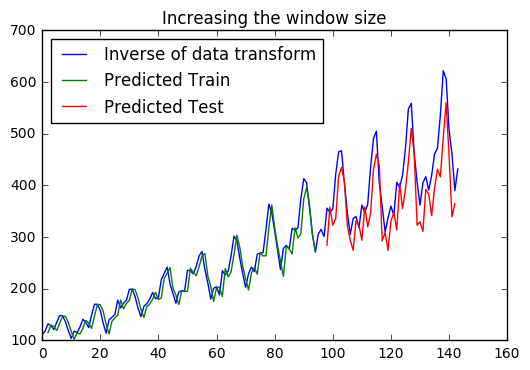

In [14]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.title("Increasing the window size")
plt.plot(scaler.inverse_transform(dataset),label="Inverse of data transform")
plt.plot(trainPredictPlot,label="Predicted Train")
plt.plot(testPredictPlot,label="Predicted Test")
plt.legend(loc=0)
plt.show()